# Lecture 16

Problème du sac à dos 0/1

Marcel Turcotte (École de science informatique et de génie électrique,
Université d’Ottawa)  
2024-11-17

## Problème

**Problème du sac à dos 0/1** : Étant donné des objets avec des
**poids** et des **valeurs** définis, l’objectif est de **maximiser la
valeur totale** en sélectionnant des objets pour un sac à dos sans
dépasser une **capacité fixe**. Chaque objet doit être soit entièrement
**inclus (1)**, soit **exclu (0)**.

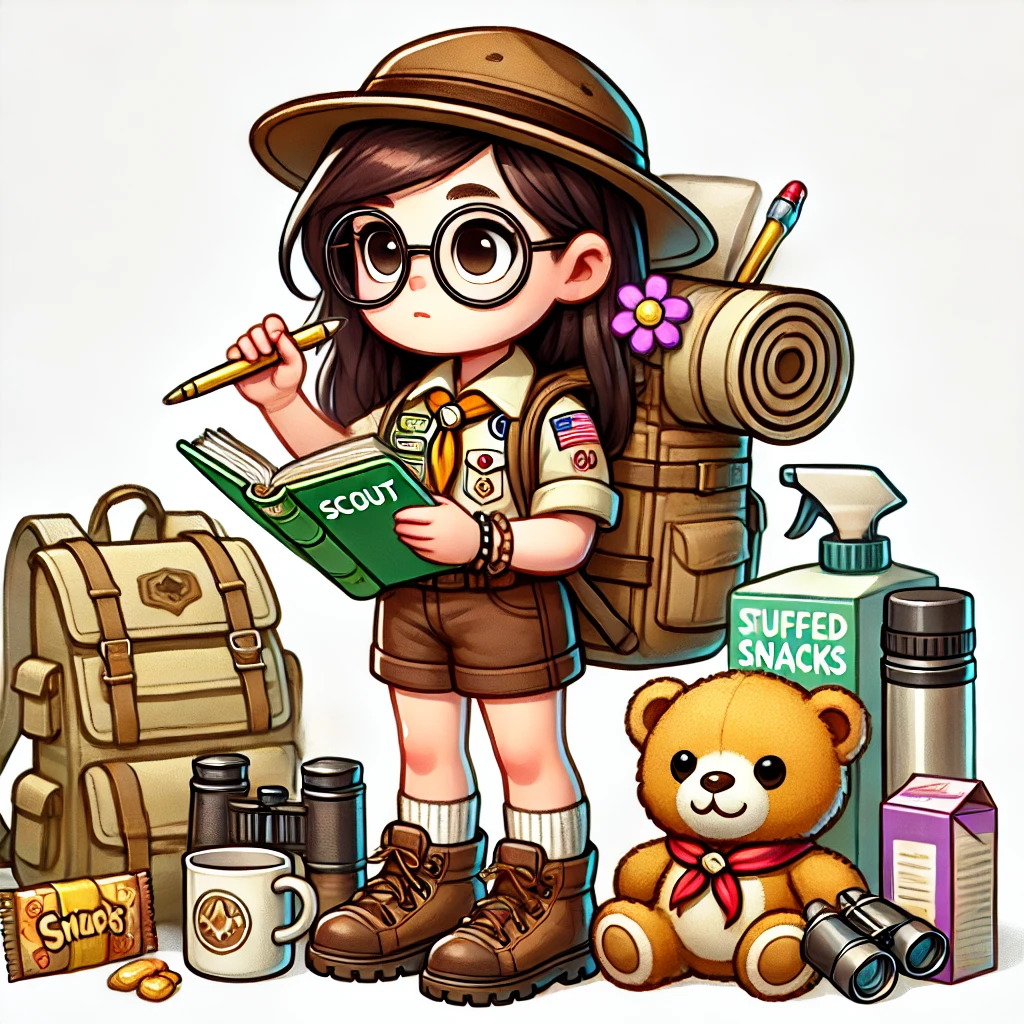

**Attribution**: Généré par DALL-E, via ChatGPT (GPT-4), OpenAI, 10
novembre 2024.

## Utilitaires

In [1]:
import requests

def read_knapsack_data(url):

    """
    Reads and processes knapsack problem data from a given URL.
    
    Args:
        url (str): The URL pointing to the data file.
        
    Returns:
        values, weights, capacity
        
    Raises:
        Exception: If there is an issue with fetching the data or parsing the content.
    """

    try:
        # Fetch data from the URL
        response = requests.get(url)
        
        # Raise an error if the request was unsuccessful
        response.raise_for_status()
        
        # Split the data into lines
        lines = response.text.strip().split('\n')
        
        # Parse the number of items
        num_items = int(lines[0].strip())
        
        # Parse the values and weights lists
        values = list(map(int, lines[1].strip().split()))
        weights = list(map(int, lines[2].strip().split()))
        
        # Parse the capacity
        capacity = int(lines[3].strip())
        
        # Validate that the number of items matches the length of values and weights
        if len(values) != num_items or len(weights) != num_items:
            raise ValueError("The number of items does not match the length of values or weights list.")
        
        # Return the values, weights, and capacity
        return np.array(values), np.array(weights), capacity
    
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from URL: {e}")
        raise
    except ValueError as e:
        print(f"Error processing data: {e}")
        raise
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        raise

## Algorithmes gloutons

> ** \[@Skiena:2008aa, page 192\]**
>
> Les algorithmes gloutons prennent la décision de ce qu’il faut faire
> ensuite en sélectionnant la meilleure option locale parmi toutes les
> choix disponibles, sans tenir compte de la structure globale.

### Glouton par poids

Une stratégie gloutonne possible consiste à sélectionner les objets par
ordre croissant de poids jusqu’à ce que le total dépasse la capacité.

In [2]:
def greedy_knapsack_weight(weights, values, capacity):

    """
    Greedy algorithm for the 0/1 Knapsack Problem based on weigth.

    Args:
        weights (np.ndarray): Weights of the items.
        values (np.ndarray): Values of the items.
        capacity (int): Capacity of the knapsack.

    Returns:
        tuple: Selected items (binary array), total value, total weight.
    """

    num_items = len(weights)

    # Create a list of items with their values and original indices
    items = list(zip(weights, values, range(num_items)))

    # Sort items by weight in increasing order
    items.sort()
    
    total_weight = 0
    total_value = 0
    solution = np.zeros(num_items, dtype=int)
    
    # Select items based on the sorted order
    for w, v, idx in items:
        if total_weight + w <= capacity:
            solution[idx] = 1
            total_weight += w
            total_value += v
        else:
            continue  # Skip items that would exceed the capacity
    
    return solution, total_value, total_weight

### Glouton par valeur

Une autre stratégie gloutonne consiste à sélectionner les objets par
ordre décroissant de valeur jusqu’à ce que le total dépasse la capacité.

In [3]:
import numpy as np

def greedy_knapsack_value(weights, values, capacity):

    """
    Greedy algorithm for the 0/1 Knapsack Problem based on value.

    Args:
        weights (np.ndarray): Weights of the items.
        values (np.ndarray): Values of the items.
        capacity (int): Capacity of the knapsack.

    Returns:
        tuple: Selected items (binary array), total value, total weight.
    """

    num_items = len(weights)

    # Create a list of items with their values and original indices
    items = list(zip(values, weights, range(num_items)))

    # Sort items by value in decreasing order
    items.sort(reverse=True)
    
    total_weight = 0
    total_value = 0
    solution = np.zeros(num_items, dtype=int)
    
    # Select items based on the sorted order
    for v, w, idx in items:
        if total_weight + w <= capacity:
            solution[idx] = 1
            total_weight += w
            total_value += v
        else:
            continue  # Skip items that would exceed the capacity
    
    return solution, total_value, total_weight

### Glouton par ratio

Basé sur le ratio valeur/poids.

In [4]:
def greedy_knapsack_ratio(weights, values, capacity):

    """
    Greedy algorithm for the 0/1 Knapsack Problem based on value-to-weight ratio.

    Args:
        weights (np.ndarray): Weights of the items.
        values (np.ndarray): Values of the items.
        capacity (int): Capacity of the knapsack.

    Returns:
        tuple: Selected items (binary array), total value, total weight.
    """

    num_items = len(weights)

    # Calculate value-to-weight ratio for each item
    ratio = values / weights

    # Create a list of items with their ratios and original indices
    items = list(zip(ratio, values, weights, range(num_items)))

    # Sort items by ratio in decreasing order
    items.sort(reverse=True)
    
    total_weight = 0
    total_value = 0
    solution = np.zeros(num_items, dtype=int)
    
    # Select items based on the sorted order
    for r, v, w, idx in items:
        if total_weight + w <= capacity:
            solution[idx] = 1
            total_weight += w
            total_value += v
        else:
            continue  # Skip items that would exceed the capacity
    
    return solution, total_value, total_weight

## Algorithme génétique

Voir les notes de cours pour les détails.

In [5]:
import random

def initialize_population(pop_size, num_items):
    """
    Initialize the population with random binary strings.

    Args:
        pop_size (int): Number of individuals in the population.
        num_items (int): Number of items in the knapsack problem.

    Returns:
        np.ndarray: Initialized population.
    """
    return np.random.randint(2, size=(pop_size, num_items))

In [6]:
def evaluate_fitness(population, weights, values, capacity, penalty_factor=10):
    """
    Evaluate the fitness of each individual in the population.

    Args:
        population (np.ndarray): Current population.
        weights (np.ndarray): Weights of the items.
        values (np.ndarray): Values of the items.
        capacity (int): Capacity of the knapsack.
        penalty_factor (float): Penalty factor for exceeding capacity.

    Returns:
        np.ndarray: Fitness values for the population.
    """
    total_weights = np.dot(population, weights)
    total_values = np.dot(population, values)
    penalties = penalty_factor * np.maximum(0, total_weights - capacity)
    fitness = total_values - penalties
    return fitness

In [7]:
def tournament_selection(population, fitness, tournament_size):
    """
    Select individuals from the population using tournament selection.

    Args:
        population (np.ndarray): Current population.
        fitness (np.ndarray): Fitness values of the population.
        tournament_size (int): Number of individuals in each tournament.

    Returns:
        np.ndarray: Selected parents.
    """
    pop_size = population.shape[0]
    selected_indices = []
    for _ in range(pop_size):
        participants = np.random.choice(pop_size, tournament_size, replace=False)
        best = participants[np.argmax(fitness[participants])]
        selected_indices.append(best)
    return population[selected_indices]

In [8]:
def roulette_selection(population, fitness):
    """
    Select individuals from the population using roulette wheel selection.

    Args:
        population (np.ndarray): Current population.
        fitness (np.ndarray): Fitness values of the population.

    Returns:
        np.ndarray: Selected parents.
    """
    # Adjust fitness to be non-negative
    min_fitness = np.min(fitness)
    adjusted_fitness = fitness - min_fitness + 1e-6  # small epsilon to avoid zero division
    total_fitness = np.sum(adjusted_fitness)
    probabilities = adjusted_fitness / total_fitness
    pop_size = population.shape[0]
    selected_indices = np.random.choice(pop_size, size=pop_size, p=probabilities)
    return population[selected_indices]

In [9]:
def single_point_crossover(parents, crossover_rate):
    """
    Perform single-point crossover on the parents.

    Args:
        parents (np.ndarray): Selected parents.
        crossover_rate (float): Probability of crossover.

    Returns:
        np.ndarray: Offspring after crossover.
    """
    num_parents, num_genes = parents.shape
    np.random.shuffle(parents)
    offspring = []
    for i in range(0, num_parents, 2):
        parent1 = parents[i]
        parent2 = parents[i+1 if i+1 < num_parents else 0]
        child1 = parent1.copy()
        child2 = parent2.copy()
        if np.random.rand() < crossover_rate:
            point = np.random.randint(1, num_genes)  # Crossover point
            child1[:point], child2[:point] = parent2[:point], parent1[:point]
        offspring.append(child1)
        offspring.append(child2)
    return np.array(offspring)

In [10]:
def uniform_crossover(parents, crossover_rate):
    """
    Perform uniform crossover on the parents.

    Args:
        parents (np.ndarray): Selected parents.
        crossover_rate (float): Probability of crossover.

    Returns:
        np.ndarray: Offspring after crossover.
    """
    num_parents, num_genes = parents.shape
    np.random.shuffle(parents)
    offspring = []
    for i in range(0, num_parents, 2):
        parent1 = parents[i]
        parent2 = parents[i+1 if i+1 < num_parents else 0]
        child1 = parent1.copy()
        child2 = parent2.copy()
        if np.random.rand() < crossover_rate:
            mask = np.random.randint(0, 2, size=num_genes).astype(bool)
            child1[mask], child2[mask] = parent2[mask], parent1[mask]
        offspring.append(child1)
        offspring.append(child2)
    return np.array(offspring)

In [11]:
def mutation(offspring, mutation_rate):
    """
    Apply bit-flip mutation to the offspring.

    Args:
        offspring (np.ndarray): Offspring after crossover.
        mutation_rate (float): Probability of mutation for each bit.

    Returns:
        np.ndarray: Offspring after mutation.
    """
    num_offspring, num_genes = offspring.shape
    mutation_matrix = np.random.rand(num_offspring, num_genes) < mutation_rate
    offspring[mutation_matrix] = 1 - offspring[mutation_matrix]
    return offspring

In [12]:
def elitism(population, fitness, elite_size):
    """
    Preserve the top-performing individuals in the population.

    Args:
        population (np.ndarray): Current population.
        fitness (np.ndarray): Fitness values of the population.
        elite_size (int): Number of top individuals to preserve.

    Returns:
        np.ndarray: Elite individuals.
    """
    elite_indices = np.argsort(fitness)[-elite_size:]  # Get indices of top individuals
    elites = population[elite_indices]
    return elites

In [13]:
def genetic_algorithm(weights, values, capacity, pop_size=100, num_generations=200, crossover_rate=0.8,
                      mutation_rate=0.05, elite_percent=0.02, selection_type='tournament', tournament_size=3,
                      crossover_type='single_point'):
    """
    Main function to run the genetic algorithm for the 0/1 knapsack problem.

    Args:
        weights (np.ndarray): Weights of the items.
        values (np.ndarray): Values of the items.
        capacity (int): Capacity of the knapsack.
        pop_size (int): Population size.
        num_generations (int): Number of generations.
        crossover_rate (float): Probability of crossover.
        mutation_rate (float): Probability of mutation.
        elite_percent (float): Percentage of elites to preserve.
        selection_type (str): 'tournament' or 'roulette'.
        tournament_size (int): Number of individuals in tournament selection.
        crossover_type (str): 'single_point' or 'uniform'.

    Returns:
        tuple: Best solution, best value, and best weight found.
    """

    num_items = len(weights)
    elite_size = max(1, int(pop_size * elite_percent))
    population = initialize_population(pop_size, num_items)

    average_fitness_history = []
    best_fitness_history = []

    for generation in range(num_generations):
        fitness = evaluate_fitness(population, weights, values, capacity)

        # Track average and best fitness
        average_fitness = np.mean(fitness)
        best_fitness = np.max(fitness)
        average_fitness_history.append(average_fitness)
        best_fitness_history.append(best_fitness)

        # Elitism
        elites = elitism(population, fitness, elite_size)

        # Selection
        if selection_type == 'tournament':
            parents = tournament_selection(population, fitness, tournament_size)
        elif selection_type == 'roulette':
            parents = roulette_selection(population, fitness)
        else:
            raise ValueError("Invalid selection type")

        # Crossover
        if crossover_type == 'single_point':
            offspring = single_point_crossover(parents, crossover_rate)
        elif crossover_type == 'uniform':
            offspring = uniform_crossover(parents, crossover_rate)
        else:
            raise ValueError("Invalid crossover type")

        # Mutation
        offspring = mutation(offspring, mutation_rate)

        # Create new population
        population = np.vstack((elites, offspring))

        # Ensure population size
        if population.shape[0] > pop_size:
            population = population[:pop_size]
        elif population.shape[0] < pop_size:
            # Add random individuals to fill population
            num_new_individuals = pop_size - population.shape[0]
            new_individuals = initialize_population(num_new_individuals, num_items)
            population = np.vstack((population, new_individuals))

    # After all generations, return the best solution
    fitness = evaluate_fitness(population, weights, values, capacity)
    best_index = np.argmax(fitness)
    best_solution = population[best_index]
    best_value = np.dot(best_solution, values)
    best_weight = np.dot(best_solution, weights)

    return best_solution, best_value, best_weight, average_fitness_history, best_fitness_history

In [14]:
def genetic_algorithm_do_n(weights, values, capacity, pop_size=100, num_generations=200, crossover_rate=0.8,
      mutation_rate=0.05, elite_percent=0.02, selection_type='tournament', tournament_size=3, crossover_type='single_point', repeats=100):

    best_solution = None
    best_value = -1
    best_weight = -1

    best_averages = []
    best_bests = []

    for i in range(repeats):

        solution, value, weight, average_history, best_history = genetic_algorithm(weights, values, capacity, pop_size, num_generations, crossover_rate,
            mutation_rate, elite_percent, selection_type, tournament_size, crossover_type)

        if value > best_value and weight <= capacity:
            best_solution = solution
            best_value = value
            best_weight = weight
            best_averages = average_history
            best_bests = best_history

    return best_solution, best_value, best_weight, best_averages, best_bests

## Tests

Test de notre algorithme génétique sur des données de [Google
OR-Tools](https://developers.google.com/optimization/pack/knapsack).

Best Solution: [1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 0 0
 0 1 1 0 1 1 0 1 0 0 1 1 1]
Best Value: 7526
Best Weight: 848

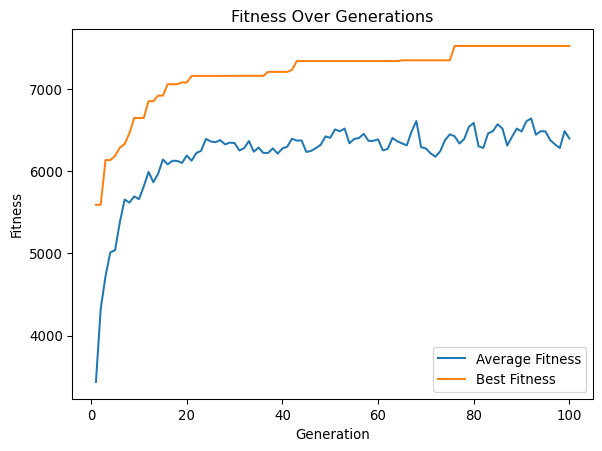

In [15]:
import matplotlib.pyplot as plt

def test_genetic_algorithm():
    # Sample data

    values = np.array([
        360, 83, 59, 130, 431, 67, 230, 52, 93, 125, 670, 892, 600, 38, 48, 147,
        78, 256, 63, 17, 120, 164, 432, 35, 92, 110, 22, 42, 50, 323, 514, 28,
        87, 73, 78, 15, 26, 78, 210, 36, 85, 189, 274, 43, 33, 10, 19, 389, 276,
        312])

    weights = np.array([
        7, 0, 30, 22, 80, 94, 11, 81, 70, 64, 59, 18, 0, 36, 3, 8, 15, 42, 9, 0,
        42, 47, 52, 32, 26, 48, 55, 6, 29, 84, 2, 4, 18, 56, 7, 29, 93, 44, 71,
        3, 86, 66, 31, 65, 0, 79, 20, 65, 52, 13])

    capacity = 850

    # Run genetic algorithm
    best_solution, best_value, best_weight, avg_fitness, best_fitness = genetic_algorithm_do_n(
        weights, values, capacity, pop_size=50, num_generations=100,
        crossover_rate=0.8, mutation_rate=0.05, elite_percent=0.02,
        selection_type='tournament', tournament_size=3)

    print("Best Solution:", best_solution)
    print("Best Value:", best_value)
    print("Best Weight:", best_weight)

    # Plot the fitness over generations
    generations = range(1, len(avg_fitness) + 1)
    plt.plot(generations, avg_fitness, label='Average Fitness')
    plt.plot(generations, best_fitness, label='Best Fitness')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Fitness Over Generations')
    plt.legend()
    plt.show()

test_genetic_algorithm()

Test de tous les algorithmes sur des données provenant de
[pages.mtu.edu/~kreher/cages/data/knapsack/](https://pages.mtu.edu/~kreher/cages/data/knapsack/).

In [16]:
import pandas as pd

BASE_URL = 'https://pages.mtu.edu/~kreher/cages/data/knapsack/'

datasets = [
    'ks_8a.dat','ks_8b.dat','ks_8c.dat','ks_8d.dat','ks_8e.dat','ks_12a.dat',
    'ks_12b.dat','ks_12c.dat','ks_12d.dat','ks_12e.dat','ks_16a.dat','ks_16b.dat',
    'ks_16c.dat','ks_16d.dat','ks_16e.dat','ks_20a.dat','ks_20b.dat','ks_20c.dat',
    'ks_20d.dat','ks_20e.dat','ks_24a.dat','ks_24b.dat','ks_24c.dat','ks_24d.dat',
    'ks_24e.dat'
]

columns = [
    'file_path', 'capacity', 
    'gw_value', 'gw_weight', 
    'gv_value', 'gw_weight', 
    'gr_value', 'gr_weight', 
    'ga_value', 'ga_weight'
]

df = pd.DataFrame(columns=columns)

for idx, file_path in enumerate(datasets):

  values, weights, capacity = read_knapsack_data(BASE_URL + file_path)

  solution, total_value, total_weight = greedy_knapsack_weight(weights, values, capacity)

  gw_value = total_value
  gw_weight = total_weight

  solution, total_value, total_weight = greedy_knapsack_value(weights, values, capacity)

  gv_value = total_value
  gv_weight = total_weight

  solution, total_value, total_weight = greedy_knapsack_ratio(weights, values, capacity)

  gr_value = total_value
  gr_weight = total_weight

  solution, total_value, total_weight, avg_fitness, best_fitness = genetic_algorithm_do_n(
        weights, values, capacity, pop_size=50, num_generations=100,
        crossover_rate=0.8, mutation_rate=0.05, elite_percent=0.02,
        selection_type='tournament', tournament_size=3, crossover_type='single_point')

  ga_value = total_value
  ga_weight = total_weight

  df.loc[idx] = [
    file_path, capacity, 
    gw_value, gw_weight, 
    gv_value, gw_weight, 
    gr_value, gr_weight, 
    ga_value, ga_weight
  ]

df.to_csv("knapsack.csv", index=False)

print(df)

     file_path  capacity  gw_value  gw_weight  gv_value  gw_weight  gr_value  \
0    ks_8a.dat   1863633    874414    1803989    925369    1803989    925369   
1    ks_8b.dat   1822718    724029    1421763    836649    1421763    724029   
2    ks_8c.dat   1609419    771637    1609296    756847    1609296    713452   
3    ks_8d.dat   2112292    749458    1558340   1006793    1558340    881823   
4    ks_8e.dat   2493250   1224805    2386238   1300939    2386238   1300939   
5   ks_12a.dat   2805213   1180238    2323972   1409053    2323972   1381444   
6   ks_12b.dat   3259036   1334963    2639964   1681436    2639964   1602435   
7   ks_12c.dat   2489815    926226    1808471   1152681    1808471   1303224   
8   ks_12d.dat   3453702   1679959    3406646   1724265    3406646   1858992   
9   ks_12e.dat   2520392   1277814    2429214   1216398    2429214   1309915   
10  ks_16a.dat   3780355   1654432    3150713   1886539    3150713   2018230   
11  ks_16b.dat   4426945   1838356    36

Dans le cadre des 25 instances du problème du sac à dos 0/1,
l’algorithme génétique a constamment surpassé les algorithmes gloutons.
Plus précisément, il a obtenu des solutions équivalentes aux meilleurs
résultats des algorithmes gloutons dans 8 cas et les a dépassées dans 17
cas, avec une amélioration allant jusqu’à 6 %.